In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [3]:
L=4
local_dim=2
bond_dim=10

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:

fname_samples="samples_ghz_plus_z_basis_only_L=4_Nmeasure=100000.npy"
samples = np.load(fname_samples)
samples_tr = torch.tensor((samples + 1)/2).to(torch.long)


In [6]:
from torch.utils.data import TensorDataset, DataLoader

In [7]:
ds = TensorDataset(samples_tr)

In [8]:
batch_size = 1024
lr = .001

In [9]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [10]:
losses = []

In [11]:
eps = 3

In [12]:
def sgd_step_at_site(mps, site_index, spin_config,
                         rotation=None, cutoff=1e-10, normalize='left'):
    """Perform SGD step WRT two-site blob with left index at the site specified"""
    psi.gauge_to(site_index)
    #two-site blob matrix at the site
    A = psi.merge(i).numpy()
    #gradient of the log-prob WRT that complex matrix
    #note that A has to updated from the conjugate!
    g=psi.grad_twosite_logprob(i, spin_config,rotation=rotation).numpy().conj()
    #perform gradient descent step, insert back into MPS
    A = A - 2 * lr * g
    psi.set_sites_from_twosite(i, A,cutoff=cutoff,normalize='left')
   

In [13]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        spinconfig = inputs[0]
    
        for i in range(L-1):
            sgd_step_at_site(psi, i, spinconfig,
                                    cutoff=1e-10,normalize='left')   
        for i in range(L-2, -1,-1):
            sgd_step_at_site(psi, i, spinconfig,
                                  cutoff=1e-10,normalize='right')
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig))
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2


In [14]:
import matplotlib.pyplot as plt

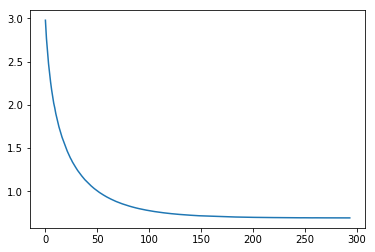

In [15]:
%matplotlib inline
plt.plot(losses)

In [16]:
from tools import generate_binary_space

In [17]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [18]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0000
tensor([1, 1, 1, 0]) has probability 0.0001
tensor([1, 1, 0, 1]) has probability 0.0001
tensor([1, 1, 0, 0]) has probability 0.0000
tensor([1, 0, 1, 1]) has probability 0.0000
tensor([1, 0, 1, 0]) has probability 0.4990
tensor([1, 0, 0, 1]) has probability 0.0000
tensor([1, 0, 0, 0]) has probability 0.0000
tensor([0, 1, 1, 1]) has probability 0.0001
tensor([0, 1, 1, 0]) has probability 0.0001
tensor([0, 1, 0, 1]) has probability 0.5002
tensor([0, 1, 0, 0]) has probability 0.0000
tensor([0, 0, 1, 1]) has probability 0.0001
tensor([0, 0, 1, 0]) has probability 0.0000
tensor([0, 0, 0, 1]) has probability 0.0001
tensor([0, 0, 0, 0]) has probability 0.0001


In [19]:
psi.shape

[(1, 2), (2, 4), (4, 2), (2, 1)]

In [21]:
psi.tensors[0].imag

Parameter containing:
tensor([[[ 0.1192,  0.0283]],

        [[-0.2725,  0.0402]]], requires_grad=True)